In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-31 04:53:59.301401: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-31 04:53:59.401210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-31 04:53:59.401249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-31 04:53:59.413975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-31 04:53:59.443554: I tensorflow/core/platform/cpu_feature_guar

In [2]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
param_names_key_rp = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1']
param_names_bias = ['b2', 'bs2', 'bl']
param_names_bias_rp = ['sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
param_names_noise_rp = ['An_homog', 'sigma8_cold_x_An_b1', 'sigma8_cold_sq_x_An_b2', 'sigma8_cold_sq_x_An_bs2', 'sigma8_cold_x_An_bl']

# inference: noiseless

In [3]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = None
tag_Anoise = None
tag_reparam = '_rp'

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pgm'], ['pk', 'bispec'], ['pk', 'pgm'], ['pk', 'bispec', 'pgm']]
#statistics_arr = [['pk']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_reparam}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}{tag_reparam}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pk_bispec = '#b0198f'
color_pgm = '#d18b13'
color_pk_pgm = '#327a3c'
color_pk_bispec_pgm = '#5e2e1f'
colors = [color_pk, color_bispec, color_pgm, color_pk_bispec, color_pk_pgm, color_pk_bispec_pgm]

In [4]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


## coverage

In [5]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tags_noise_test = None
tags_Anoise_test = None
tags_mask_test = ['']*len(tags_inf)
tag_datagen_test = ''               

n_test_eval = 100
if n_test_eval is not None:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test + f'_neval{n_test_eval}' for i in range(len(tag_stats_arr))]
else:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_neval100
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_neval100
_muchisimocks_pgm_test_p5_n1000_biaszen_p4_n1000_neval100
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_neval100
_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000_neval100
_muchisimocks_pk_bispec_pgm_test_p5_n1000_biaszen_p4_n1000_neval100


In [6]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
#param_names_show = utils.param_names_all_ordered
param_names_show = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1', \
                   'sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    # Load theta_test in original space
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    if n_test_eval is not None:
        theta_test = theta_test[:n_test_eval]
    
    # Reparameterize theta_test if tag_reparam is set
    if tag_reparam is not None and tag_reparam != '':
        # Get original param_names for theta_test
        param_names_orig = param_names_vary.copy()
        # Reparameterize theta_test to match the reparameterized param_names from inference
        theta_test, param_names_test_reparam = utils.reparameterize_theta(theta_test, param_names_orig)
    else:
        param_names_test_reparam = param_names_vary.copy()
    
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            # Use reparameterized theta_test if applicable
            if param_name_show in param_names_test_reparam:
                idx_pn_test = list(param_names_test_reparam).index(param_name_show)
                theta_true_inf.append(theta_test[:,idx_pn_test])
            else:
                # If param_name_show is not in param_names_test_reparam, it might be a reparameterized param
                # that we need to compute from original params
                theta_true_inf.append(np.full(theta_test.shape[0], np.nan))
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pgm_test_p5_n1000_biaszen_p4_n1000_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_pgm_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000_neval100_pred.npy
fn_samples_test_pred = ../re

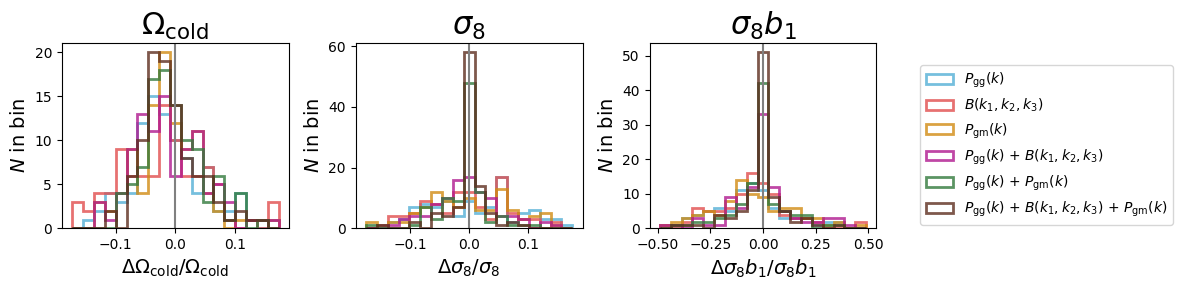

In [7]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

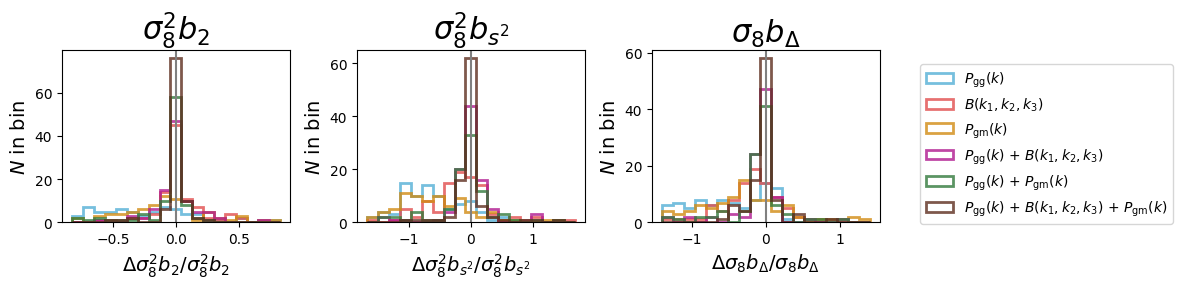

In [8]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_bias_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

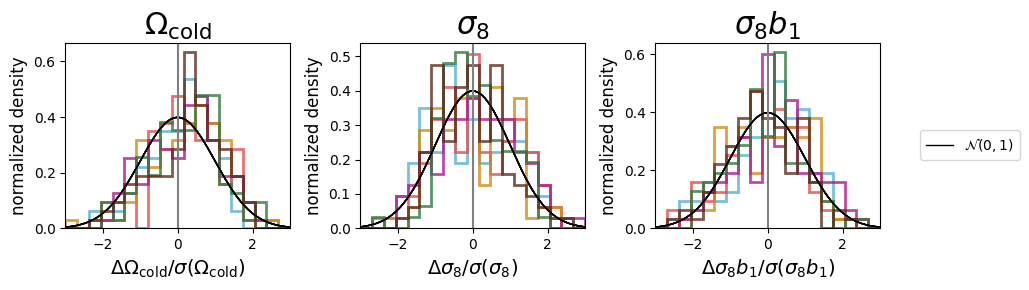

In [9]:
sigmas_from_truth_arr, chi2s_arr = plotter.plot_dists_cov_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

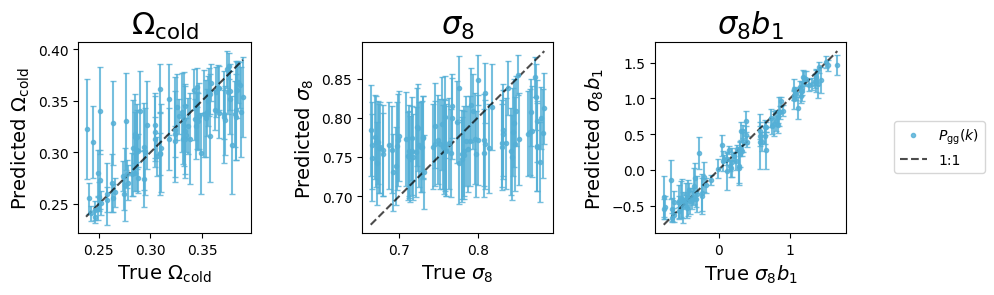

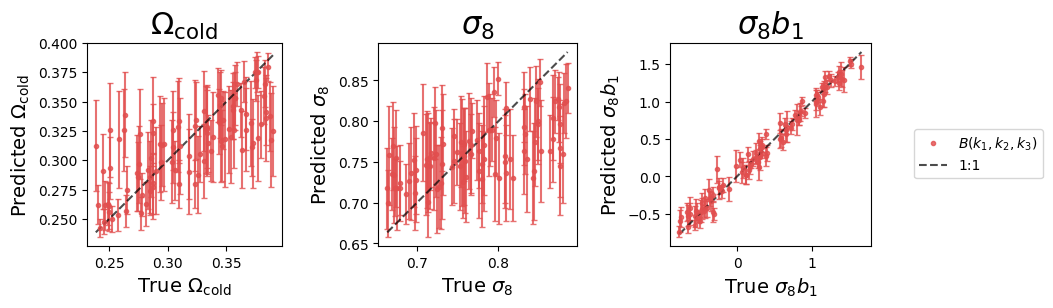

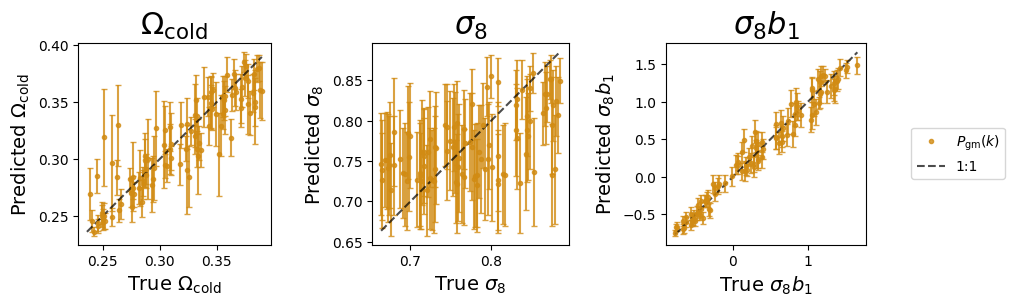

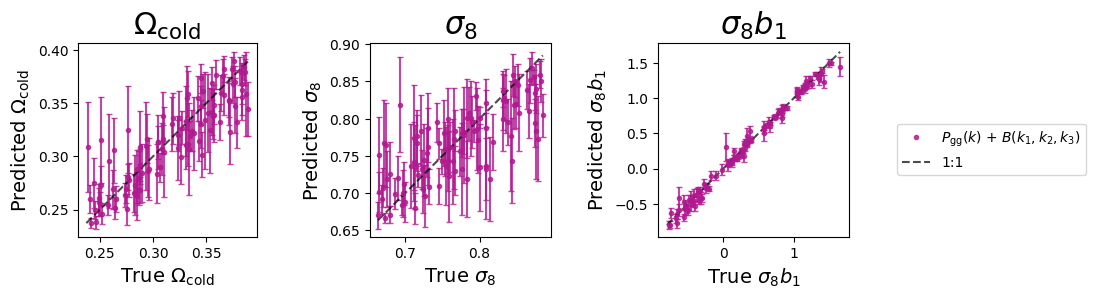

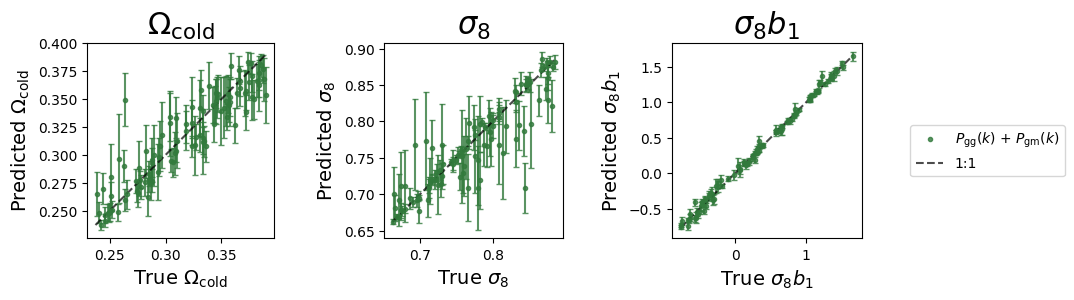

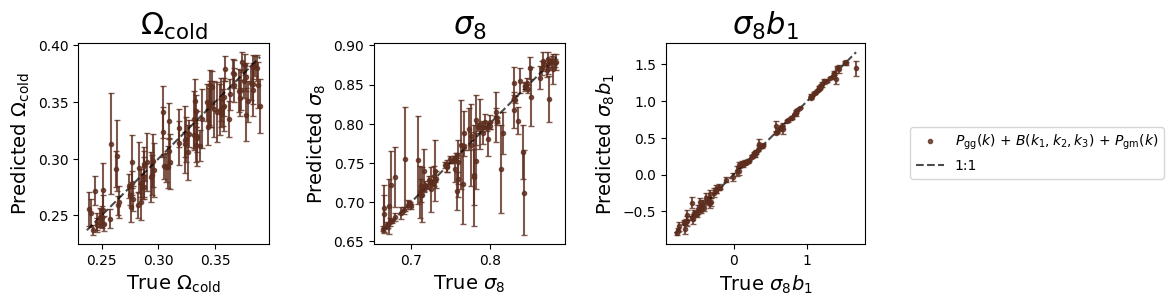

In [10]:
for idx_stat in range(len(statistics_arr)):
    fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], 
                        covs_pred_arr[idx_stat], param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

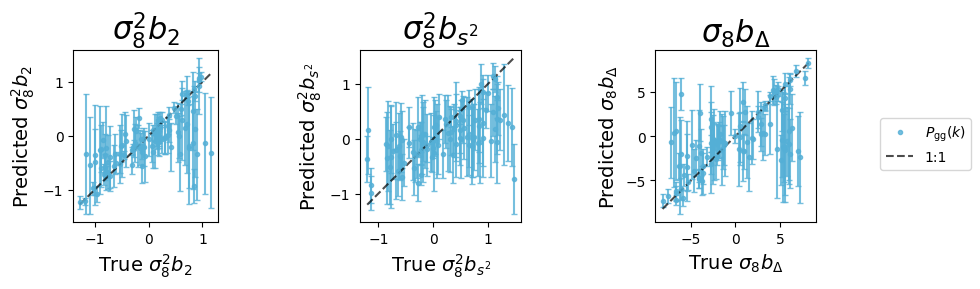

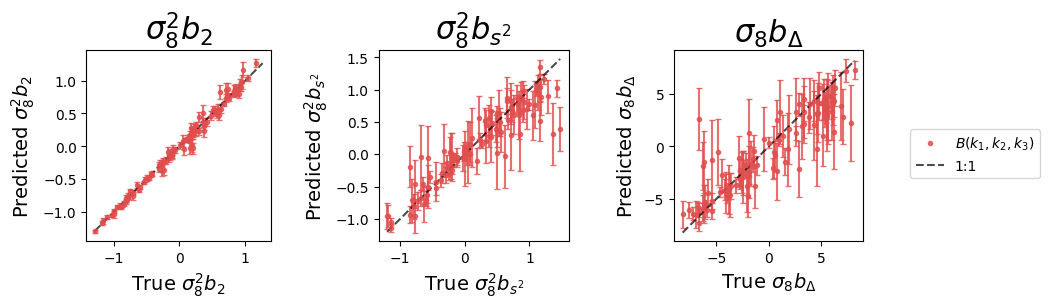

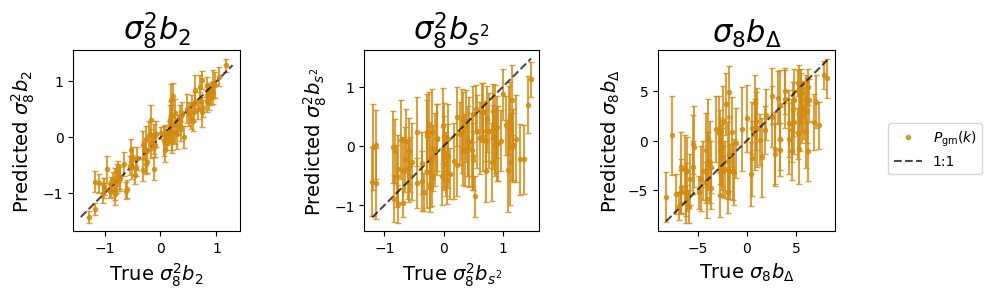

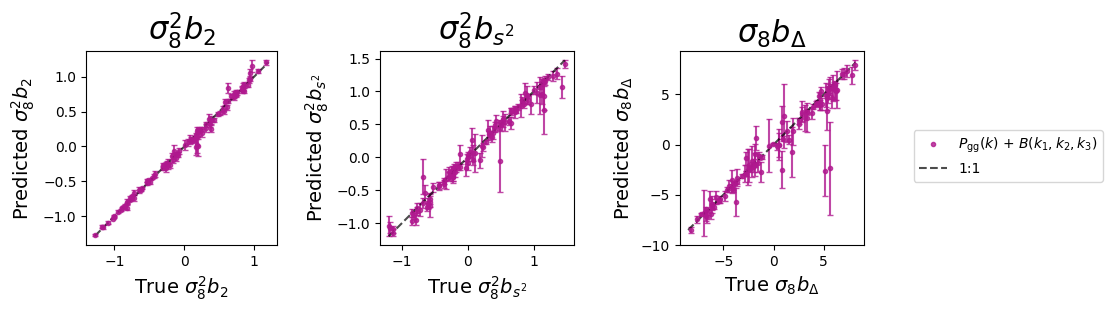

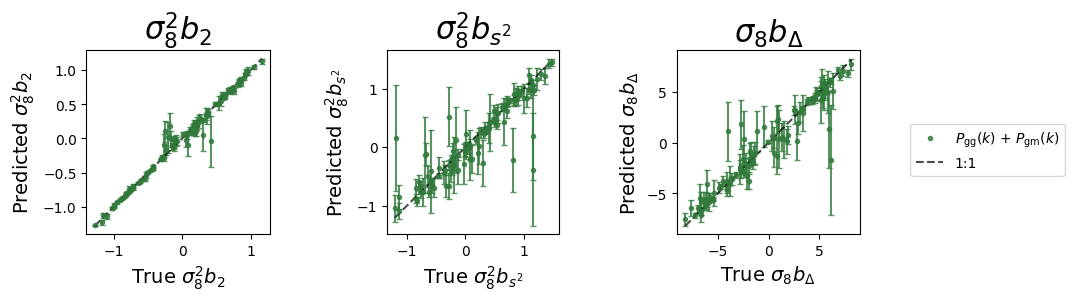

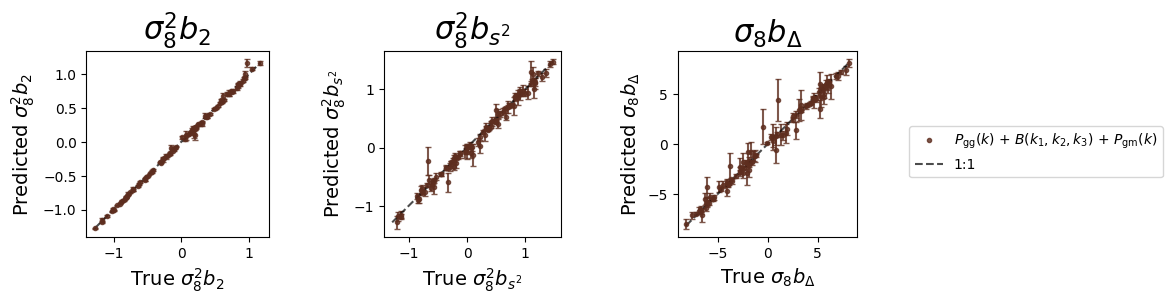

In [11]:
for idx_stat in range(len(statistics_arr)):
    fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat],
                        covs_pred_arr[idx_stat], param_names_show, 
                        param_names_plot=param_names_bias_rp, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

# inference: noisy

In [2]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'
tag_reparam = '_rp'

n_train = 10000
#statistics_arr = [['pk'], ['pgm'], ['pk', 'pgm'], ['pk', 'bispec', 'pgm']]
statistics_arr = [['pk'], ['bispec'], ['pgm'], ['pk', 'bispec'], ['pk', 'pgm'], ['pk', 'bispec', 'pgm']]
#statistics_arr = [['pk']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_reparam}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}{tag_reparam}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pk_bispec = '#b0198f'
color_pgm = '#d18b13'
color_pk_pgm = '#327a3c'
color_pk_bispec_pgm = '#5e2e1f'
colors = [color_pk, color_bispec, color_pgm, color_pk_bispec, color_pk_pgm, color_pk_bispec_pgm]

In [3]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


## coverage

In [14]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tag_biasparams_test = '_biaszen_p4_n1000'
tag_noise_test = '_noise_unit_test_p5_n1000'
tag_Anoise_test = '_Anmult_p5_n1000'
tags_mask_test = ['']*len(tags_inf)
tag_datagen_test = ''               

n_test_eval = 100
tag_paramsall_test = tag_params_test + tag_biasparams_test
if tag_noise_test is not None:
    tag_paramsall_test += tag_noise_test + tag_Anoise_test
if n_test_eval is not None:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_paramsall_test + tag_datagen_test + f'_neval{n_test_eval}' for i in range(len(tag_stats_arr))]
else:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_paramsall_test + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100
_muchisimocks_pgm_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100
_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100
_muchisimocks_pk_bispec_pgm_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100


In [15]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
#param_names_show = utils.param_names_all_ordered
# param_names_show = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1', \
#                    'sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
param_names_show = param_names_key_rp + param_names_bias_rp + param_names_noise_rp
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    # Load theta_test in original space
    theta_test = data_loader.load_theta_test(tag_params_test, tag_biasparams_test, tag_Anoise_test=tag_Anoise_test)
    if n_test_eval is not None:
        theta_test = theta_test[:n_test_eval]
    
    # Reparameterize theta_test if tag_reparam is set
    if tag_reparam is not None and tag_reparam != '':
        # Get original param_names for theta_test
        param_names_orig = param_names_vary.copy()
        # Reparameterize theta_test to match the reparameterized param_names from inference
        theta_test, param_names_test_reparam = utils.reparameterize_theta(theta_test, param_names_orig)
    else:
        param_names_test_reparam = param_names_vary.copy()
    
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            # Use reparameterized theta_test if applicable
            if param_name_show in param_names_test_reparam:
                idx_pn_test = list(param_names_test_reparam).index(param_name_show)
                theta_true_inf.append(theta_test[:,idx_pn_test])
            else:
                # If param_name_show is not in param_names_test_reparam, it might be a reparameterized param
                # that we need to compute from original params
                theta_true_inf.append(np.full(theta_test.shape[0], np.nan))
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pgm_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_b

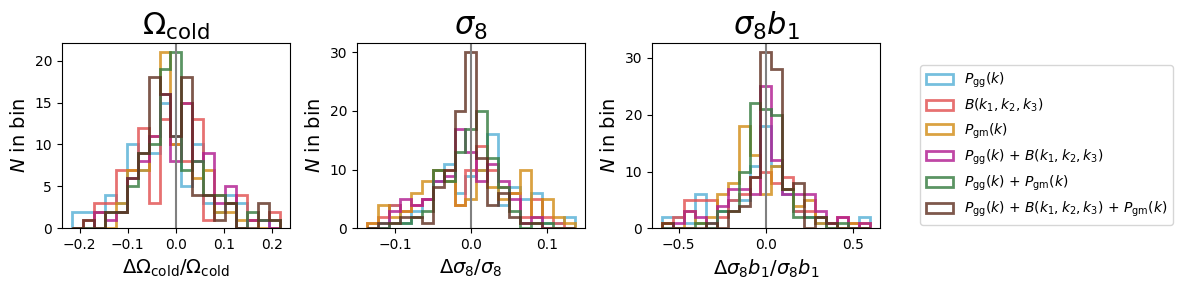

In [16]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

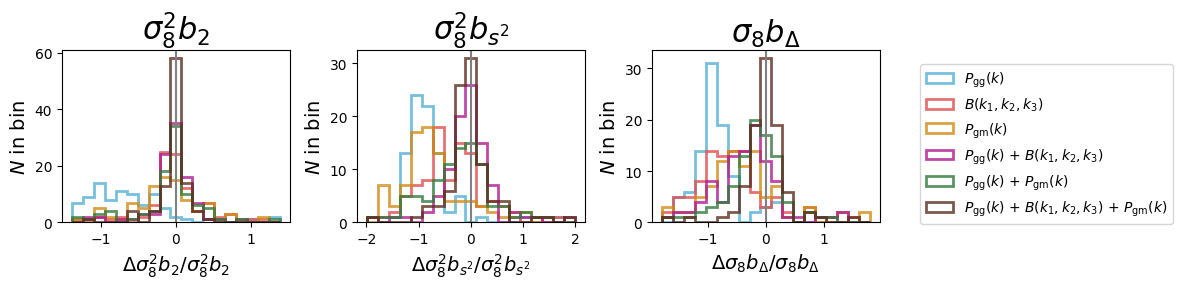

In [17]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_bias_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

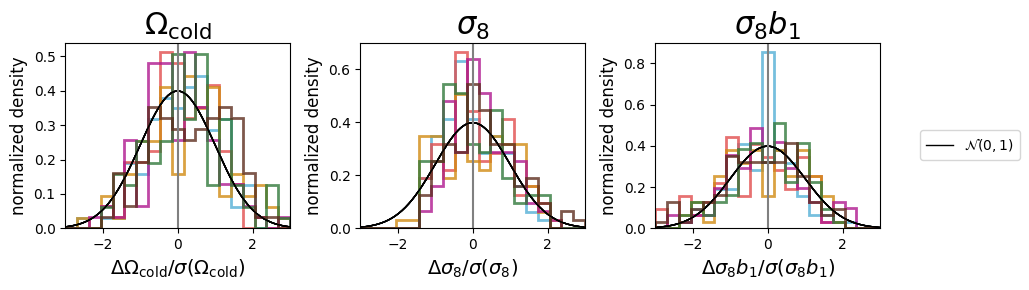

In [18]:
sigmas_from_truth_arr, chi2s_arr = plotter.plot_dists_cov_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

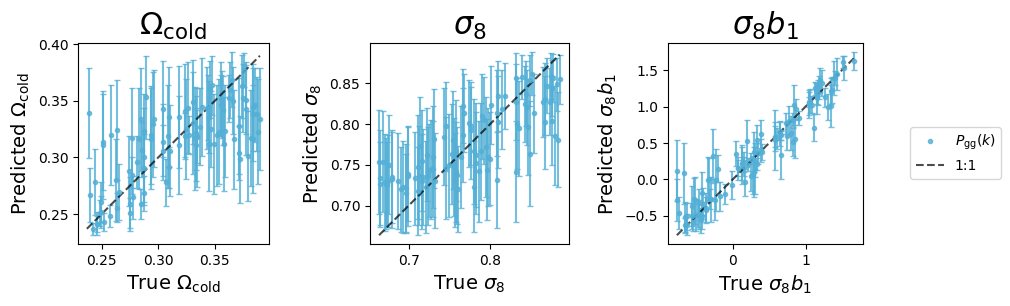

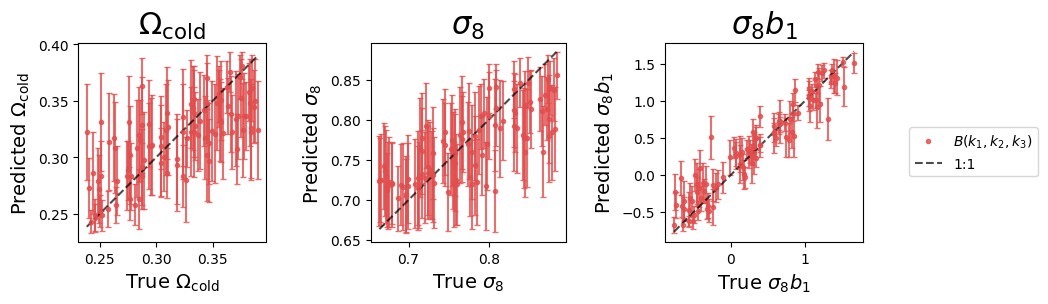

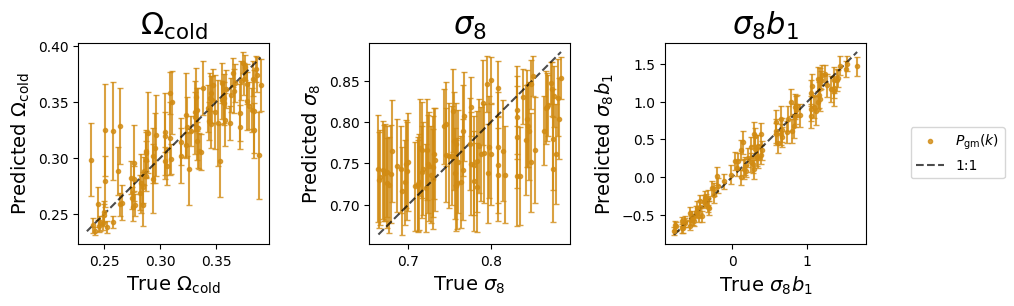

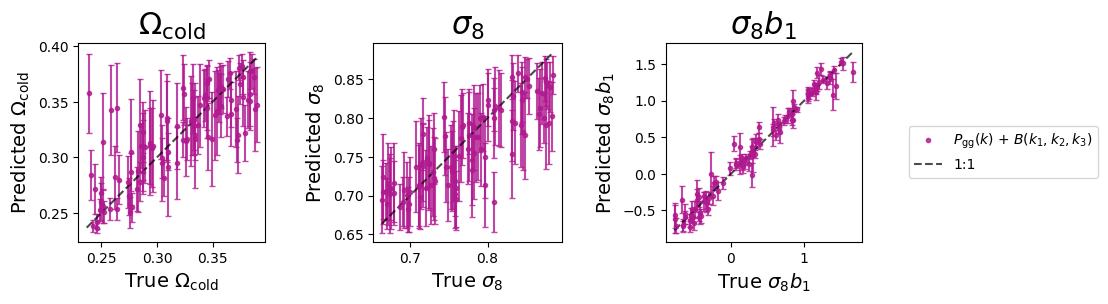

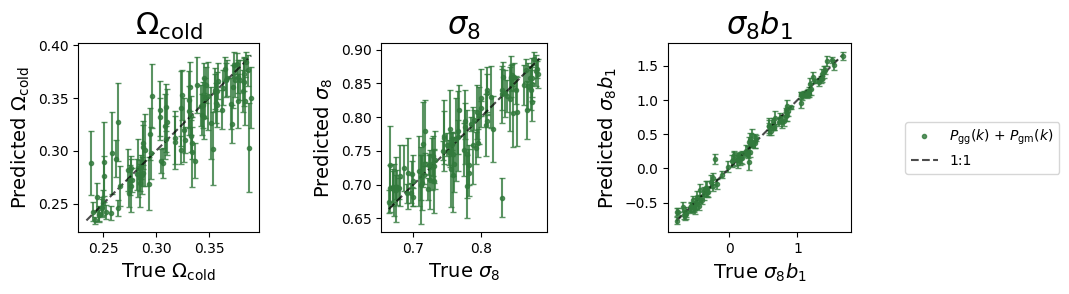

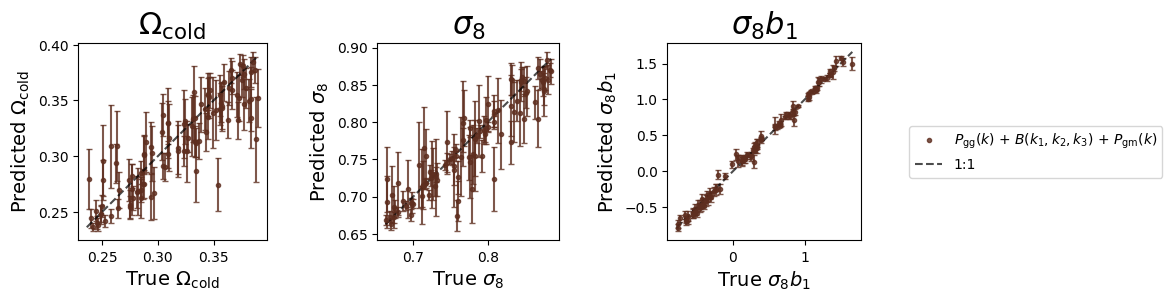

In [19]:
for idx_stat in range(len(statistics_arr)):
    fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], 
                        covs_pred_arr[idx_stat], param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

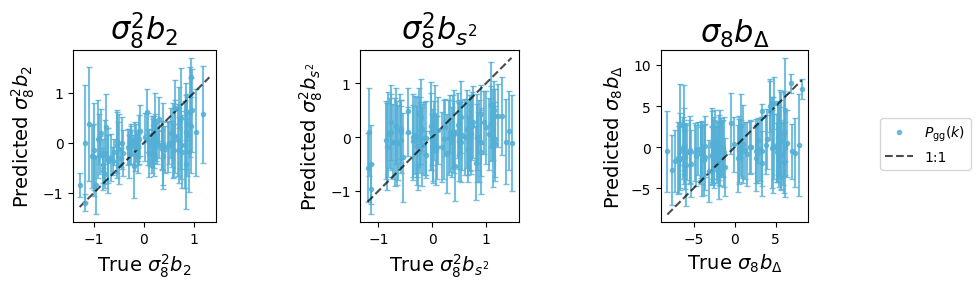

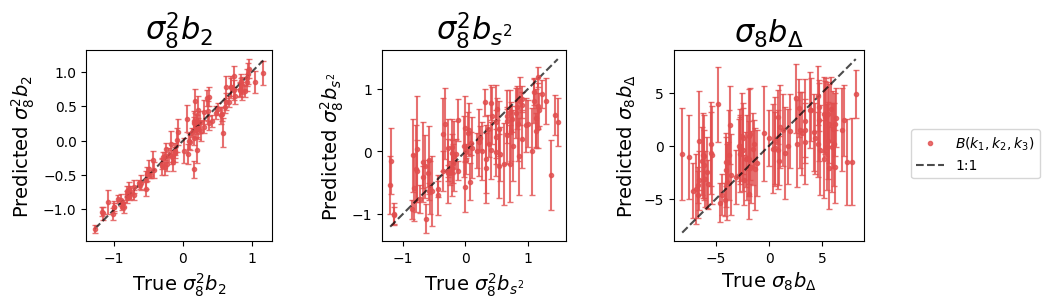

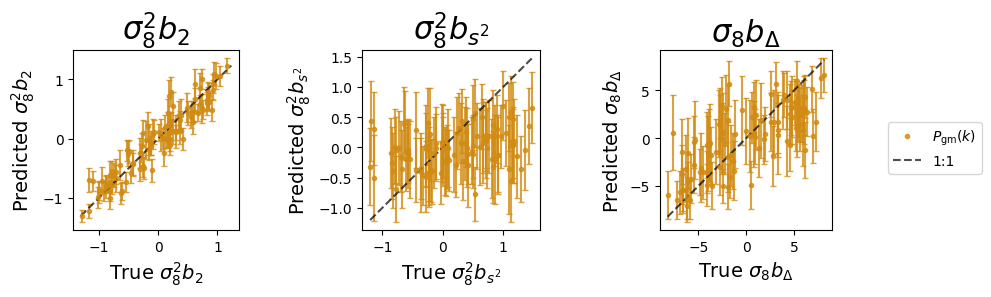

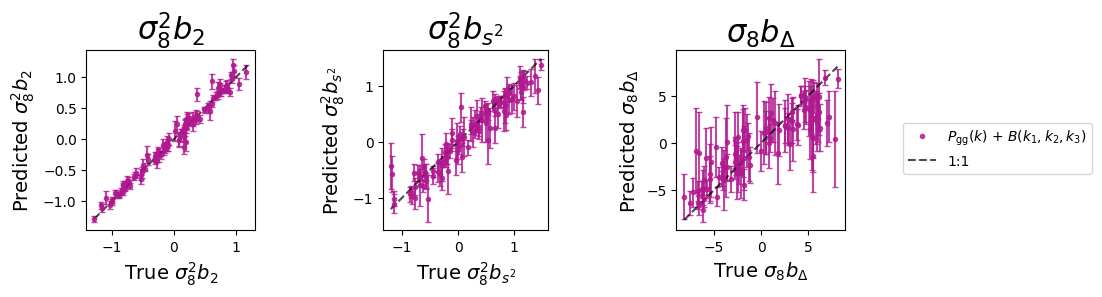

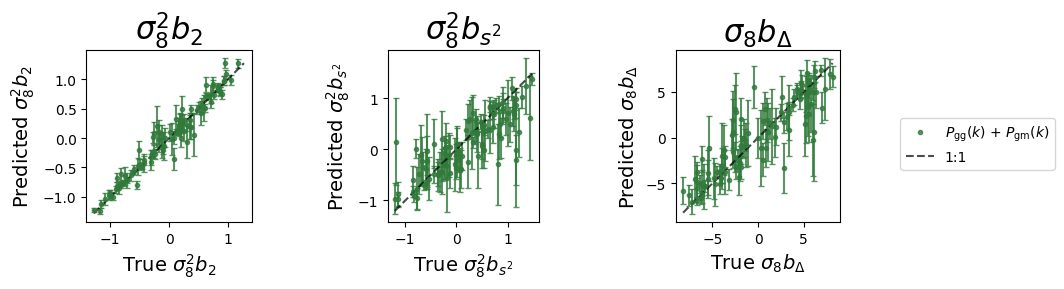

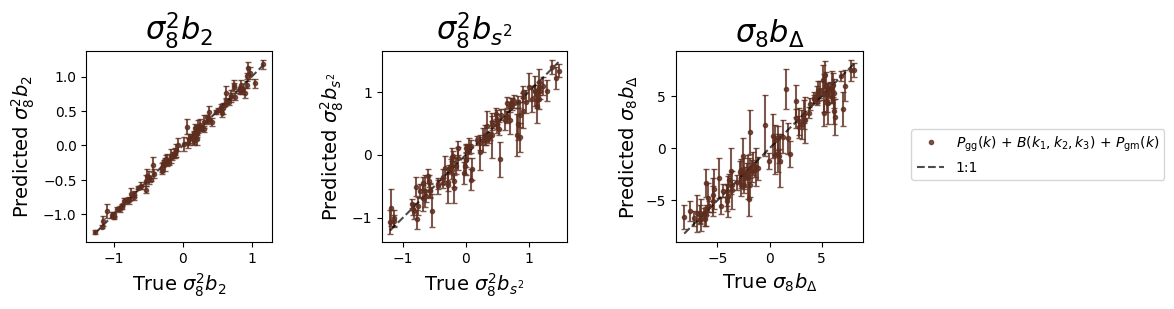

In [20]:
for idx_stat in range(len(statistics_arr)):
    fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat],
                        covs_pred_arr[idx_stat], param_names_show, 
                        param_names_plot=param_names_bias_rp, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

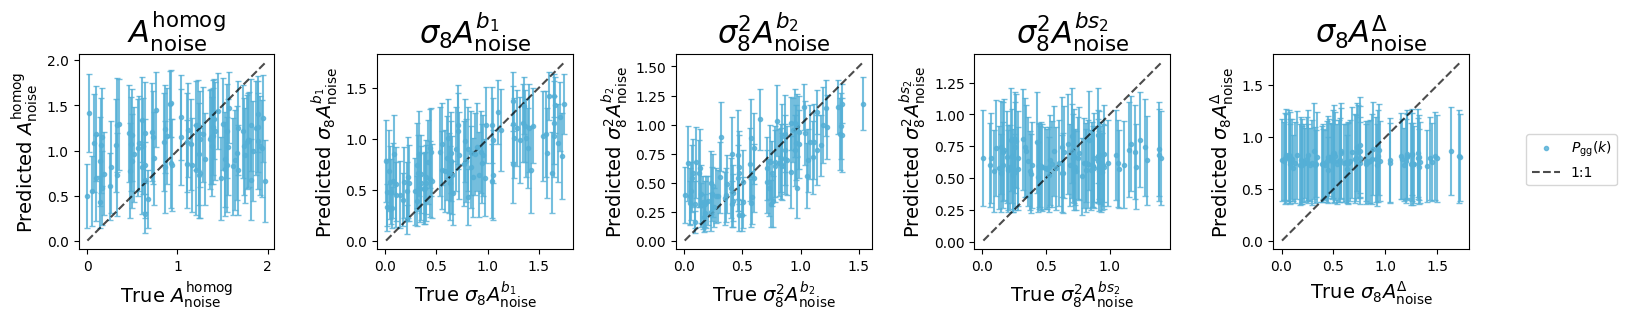

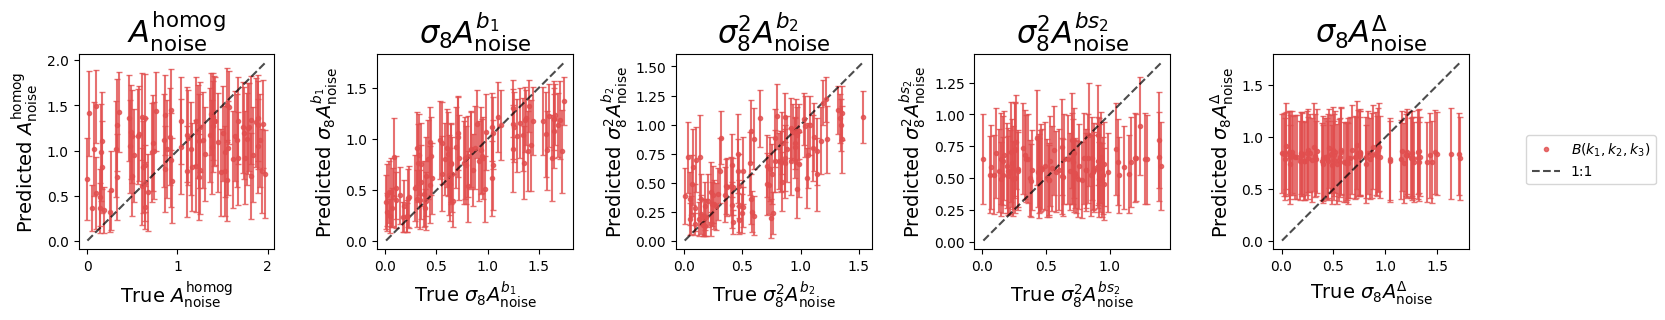

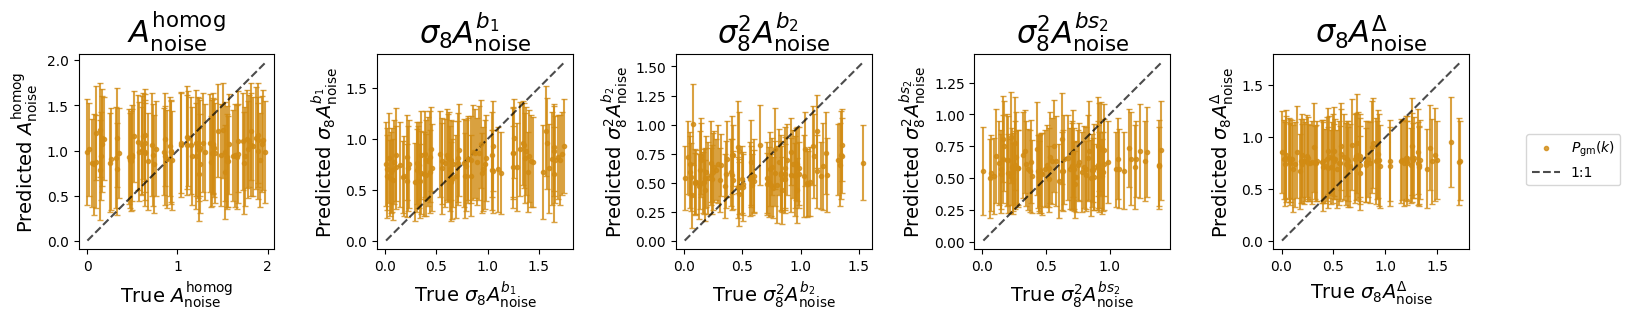

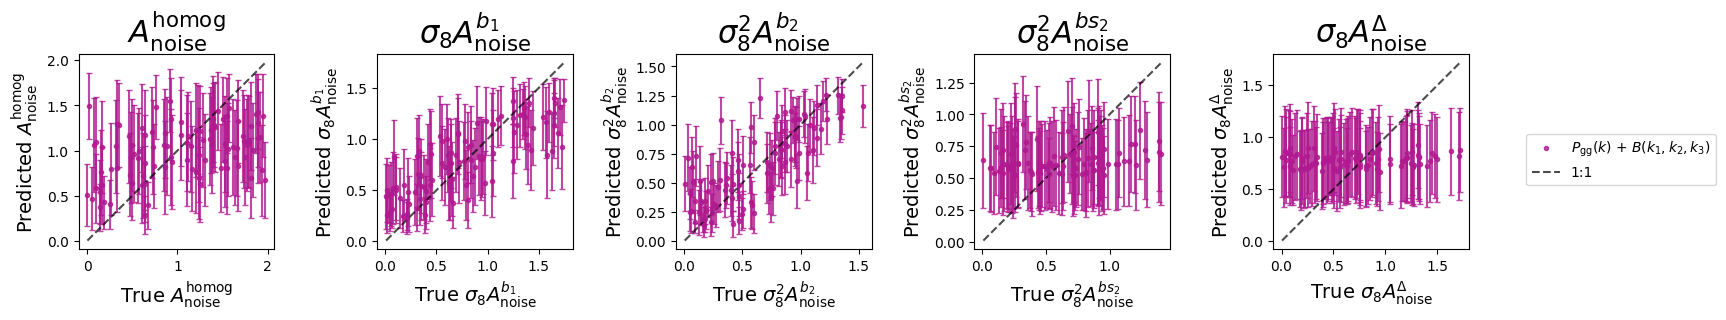

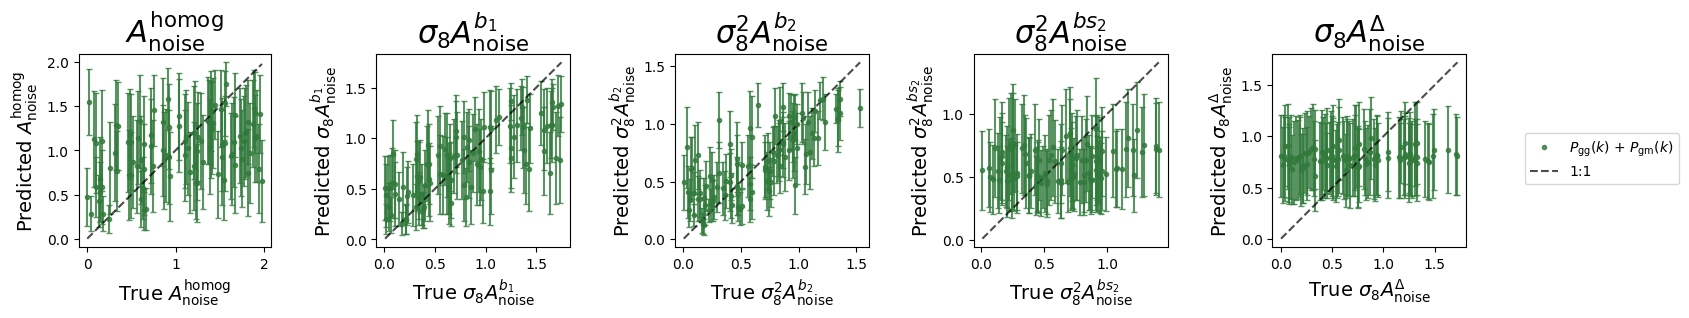

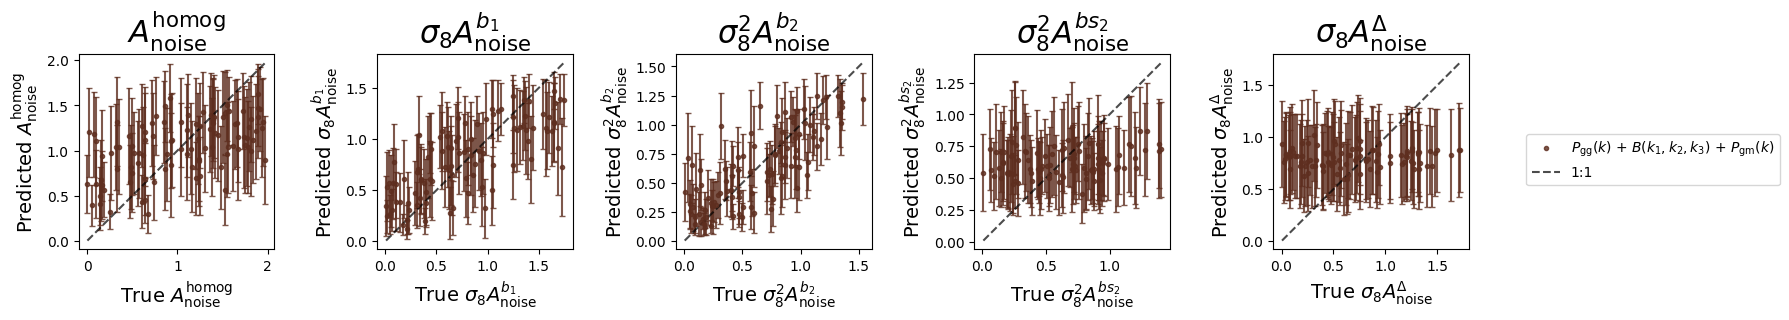

In [21]:
for idx_stat in range(len(statistics_arr)):
    fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat],
                        covs_pred_arr[idx_stat], param_names_show, 
                        param_names_plot=param_names_noise_rp, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

## shame

In [4]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.12701492 -0.33881766 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pgm_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_An

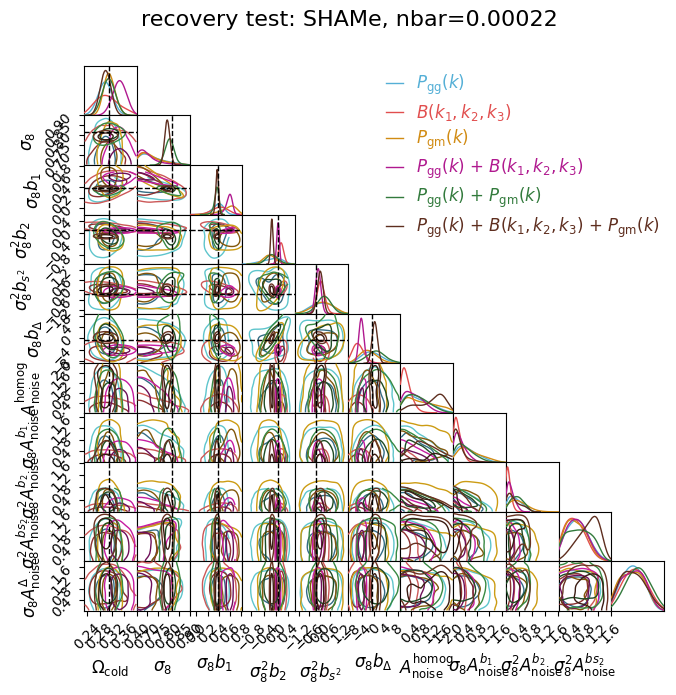

In [5]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents, fontsize_legend=12)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pgm_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_An

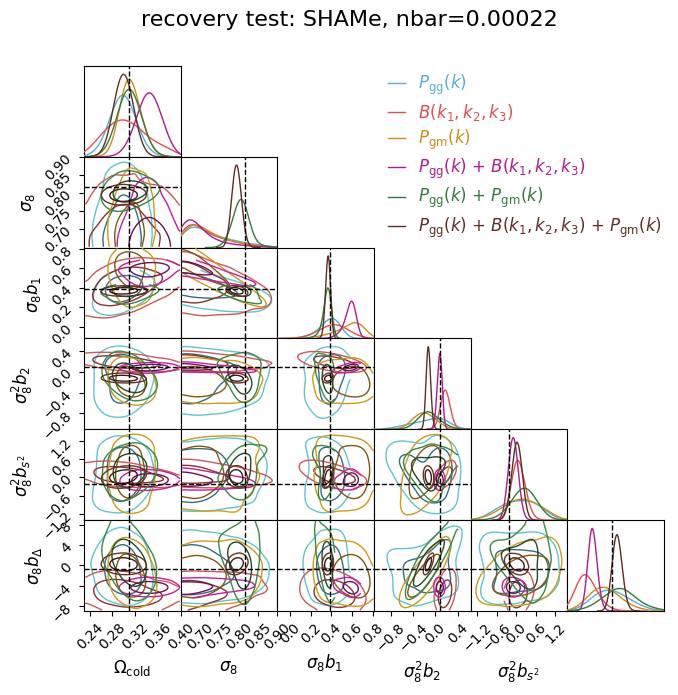

In [6]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
#param_names_contour = param_names_key_rp + param_names_bias_rp
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents, fontsize_legend=12)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pgm_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_An

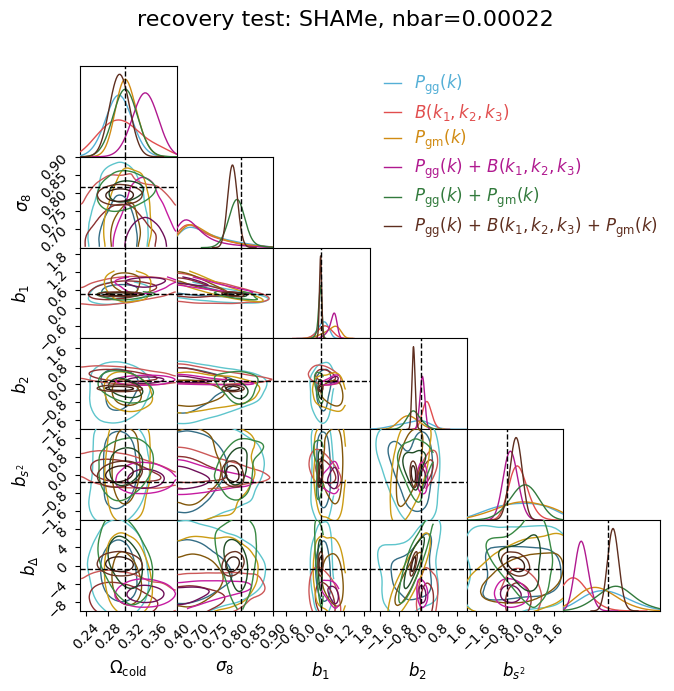

In [7]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
#param_names_contour = param_names_key_rp + param_names_bias_rp
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents, fontsize_legend=12,
                        unreparameterize=True)

# inference: noisy, kmaxbispec=0.25

In [8]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'
tag_reparam = '_rp'

n_train = 10000
#statistics_arr = [['pk'], ['pgm'], ['pk', 'pgm'], ['pk', 'bispec', 'pgm']]
statistics_arr = [['pk'], ['bispec'], ['pgm'], ['pk', 'bispec'], ['pk', 'pgm'], ['pk', 'bispec', 'pgm']]
tags_mask = ['', '_kb0.25', '', '_kb0.25', '', '_kb0.25']
#statistics_arr = [['pk']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tags_mask[i]}{tag_params}{tag_biasparams}{tag_reparam}_ntrain{n_train}' for i, tag_stats in enumerate(tag_stats_arr)]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tags_mask[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}{tag_reparam}_ntrain{n_train}' for i, tag_stats in enumerate(tag_stats_arr)]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pk_bispec = '#b0198f'
color_pgm = '#d18b13'
color_pk_pgm = '#327a3c'
color_pk_bispec_pgm = '#5e2e1f'
colors = [color_pk, color_bispec, color_pgm, color_pk_bispec, color_pk_pgm, color_pk_bispec_pgm]

In [9]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


## coverage

In [28]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tag_biasparams_test = '_biaszen_p4_n1000'
tag_noise_test = '_noise_unit_test_p5_n1000'
tag_Anoise_test = '_Anmult_p5_n1000'
tag_datagen_test = ''               

n_test_eval = 100
tag_paramsall_test = tag_params_test + tag_biasparams_test
if tag_noise_test is not None:
    tag_paramsall_test += tag_noise_test + tag_Anoise_test
if n_test_eval is not None:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask[i] + tag_paramsall_test + tag_datagen_test + f'_neval{n_test_eval}' for i in range(len(tag_stats_arr))]
else:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask[i] + tag_paramsall_test + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100
_muchisimocks_bispec_kb0.25_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100
_muchisimocks_pgm_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100
_muchisimocks_pk_bispec_kb0.25_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100
_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100
_muchisimocks_pk_bispec_pgm_kb0.25_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100


In [29]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
#param_names_show = utils.param_names_all_ordered
# param_names_show = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1', \
#                    'sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
param_names_show = param_names_key_rp + param_names_bias_rp + param_names_noise_rp
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    # Load theta_test in original space
    theta_test = data_loader.load_theta_test(tag_params_test, tag_biasparams_test, tag_Anoise_test=tag_Anoise_test)
    if n_test_eval is not None:
        theta_test = theta_test[:n_test_eval]
    
    # Reparameterize theta_test if tag_reparam is set
    if tag_reparam is not None and tag_reparam != '':
        # Get original param_names for theta_test
        param_names_orig = param_names_vary.copy()
        # Reparameterize theta_test to match the reparameterized param_names from inference
        theta_test, param_names_test_reparam = utils.reparameterize_theta(theta_test, param_names_orig)
    else:
        param_names_test_reparam = param_names_vary.copy()
    
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            # Use reparameterized theta_test if applicable
            if param_name_show in param_names_test_reparam:
                idx_pn_test = list(param_names_test_reparam).index(param_name_show)
                theta_true_inf.append(theta_test[:,idx_pn_test])
            else:
                # If param_name_show is not in param_names_test_reparam, it might be a reparameterized param
                # that we need to compute from original params
                theta_true_inf.append(np.full(theta_test.shape[0], np.nan))
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_kb0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_bispec_kb0.25_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pgm_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kb0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_t

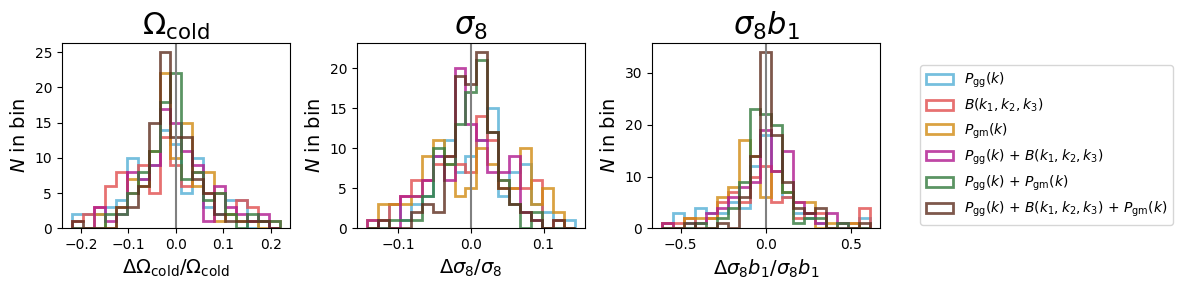

In [30]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

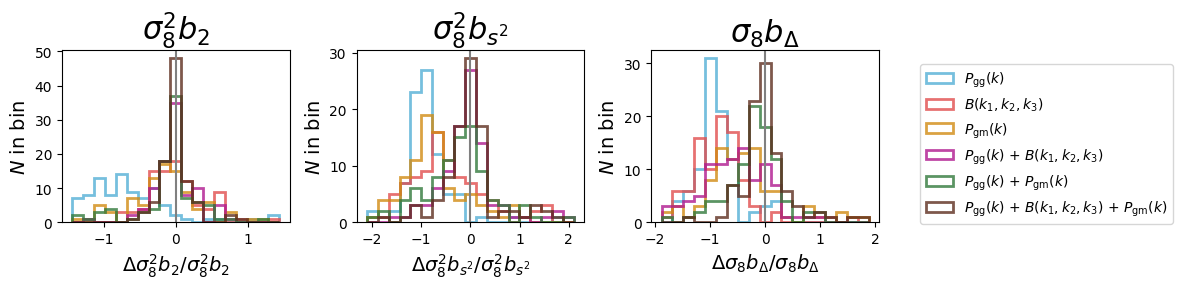

In [31]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_bias_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

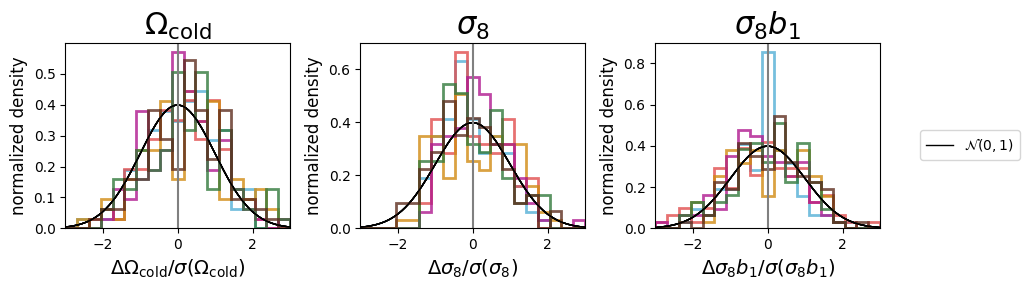

In [32]:
sigmas_from_truth_arr, chi2s_arr = plotter.plot_dists_cov_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

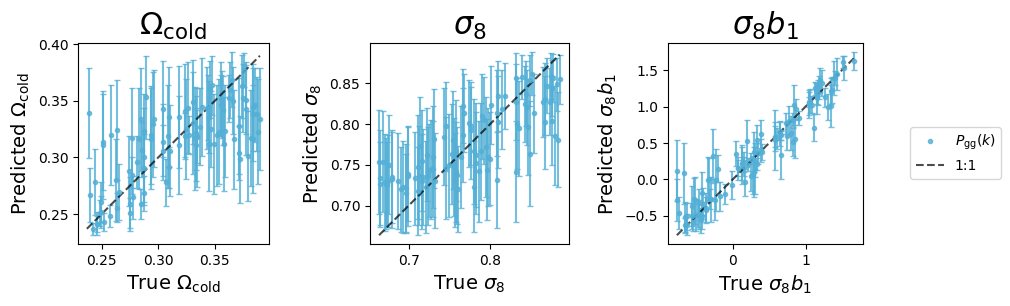

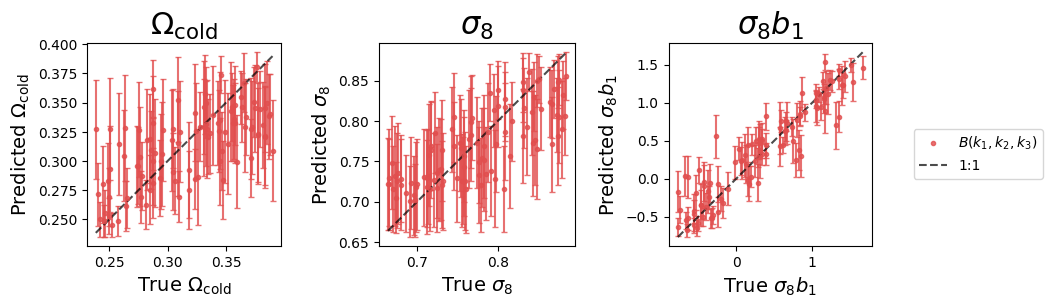

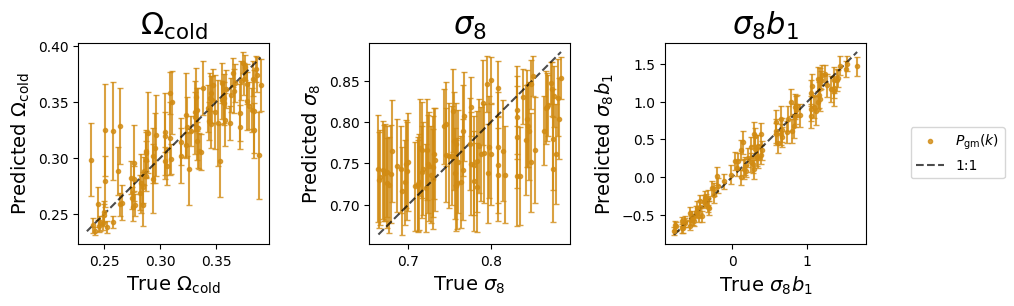

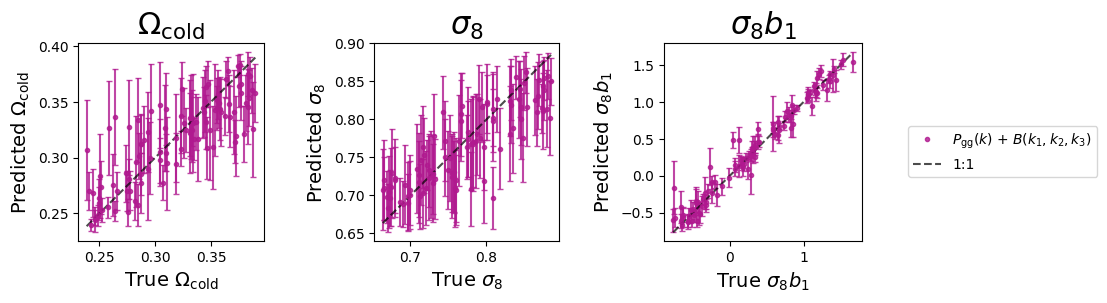

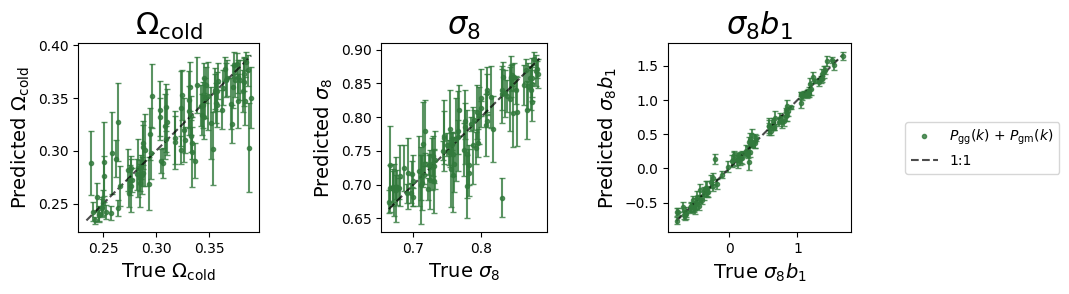

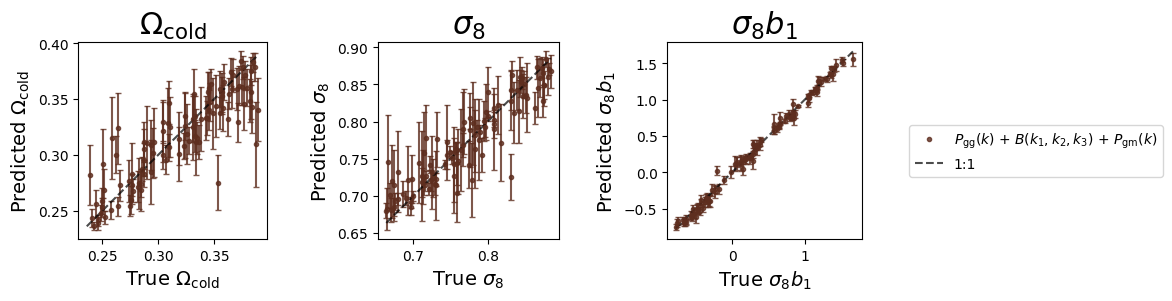

In [33]:
for idx_stat in range(len(statistics_arr)):
    fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], 
                        covs_pred_arr[idx_stat], param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

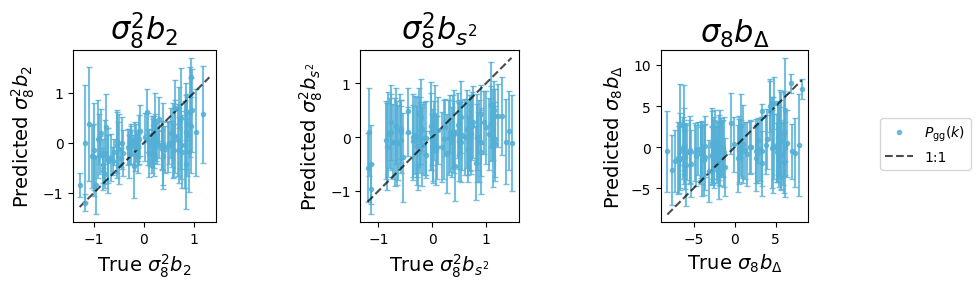

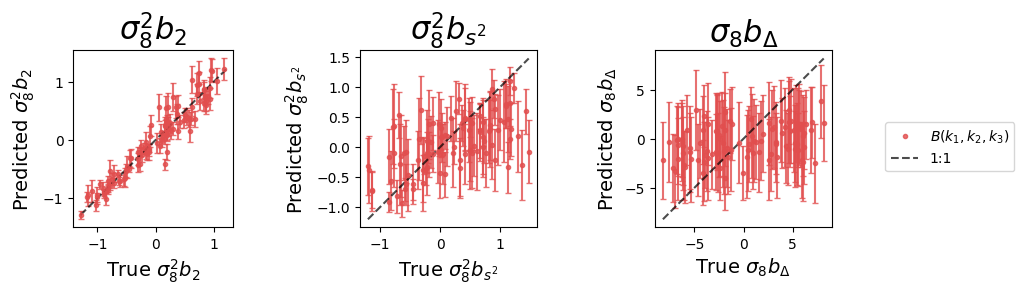

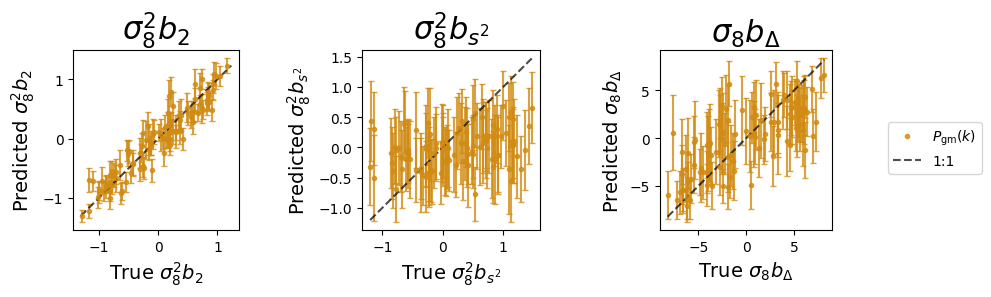

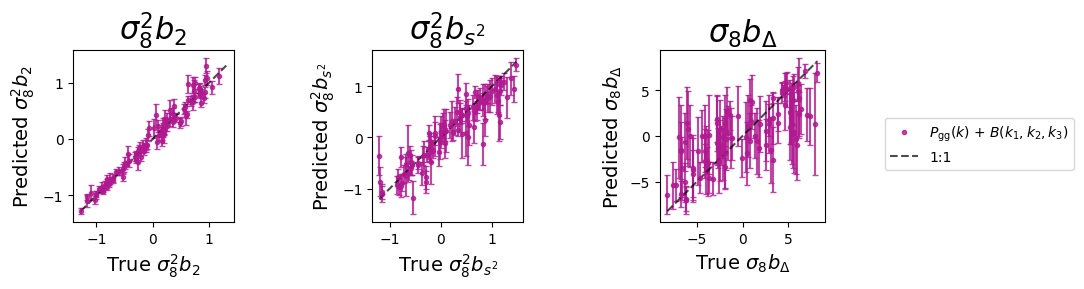

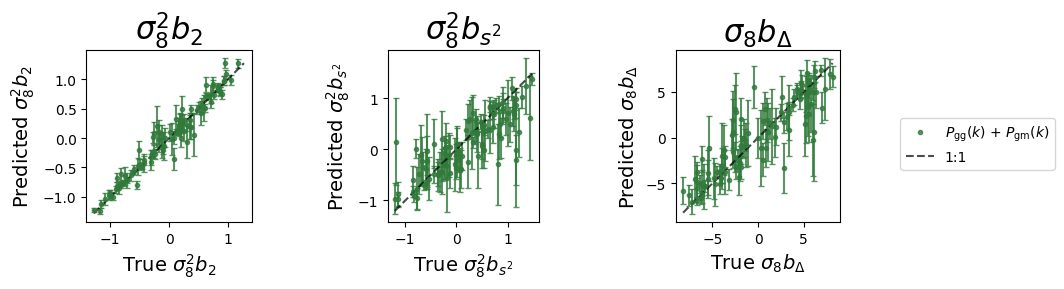

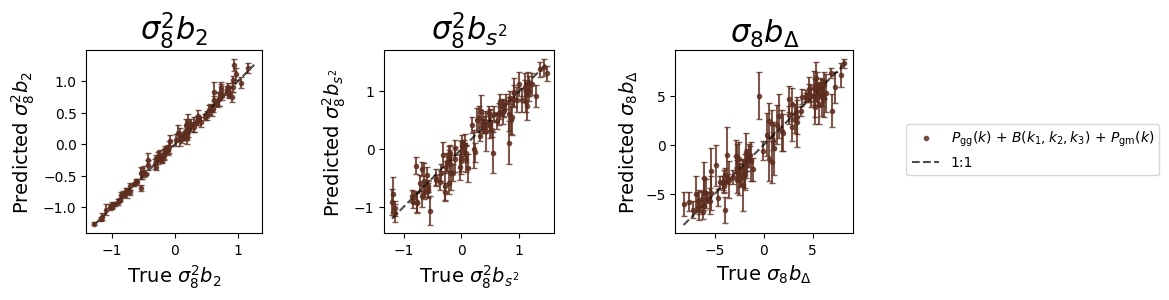

In [34]:
for idx_stat in range(len(statistics_arr)):
    fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat],
                        covs_pred_arr[idx_stat], param_names_show, 
                        param_names_plot=param_names_bias_rp, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

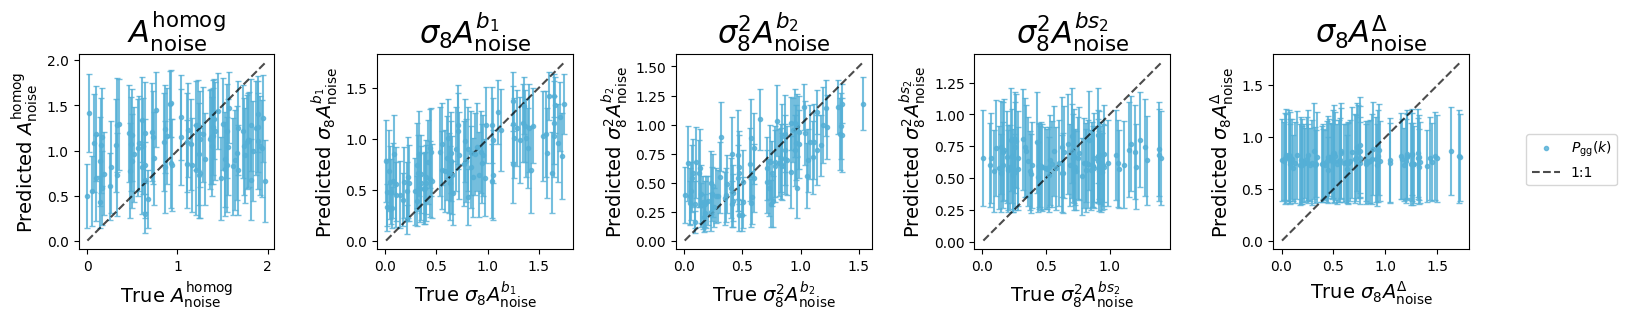

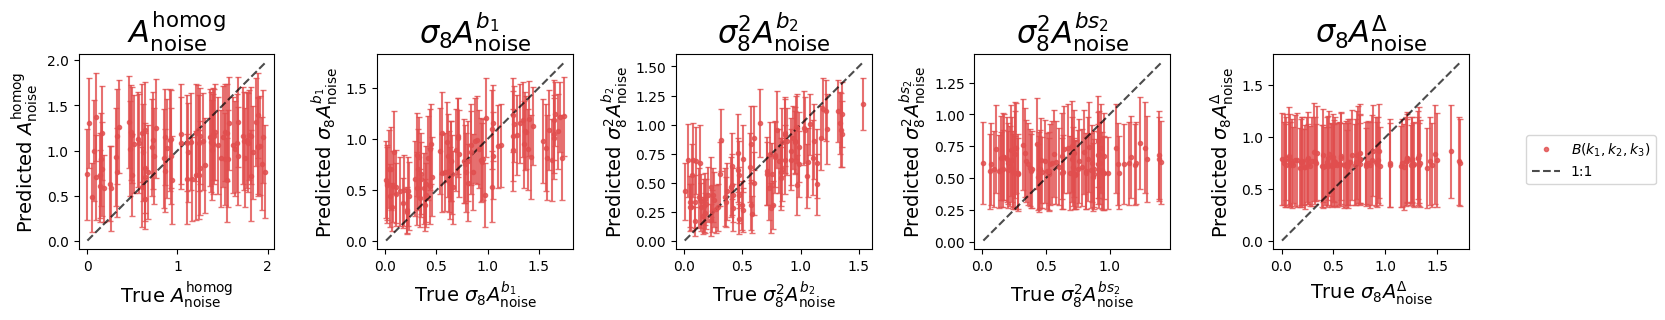

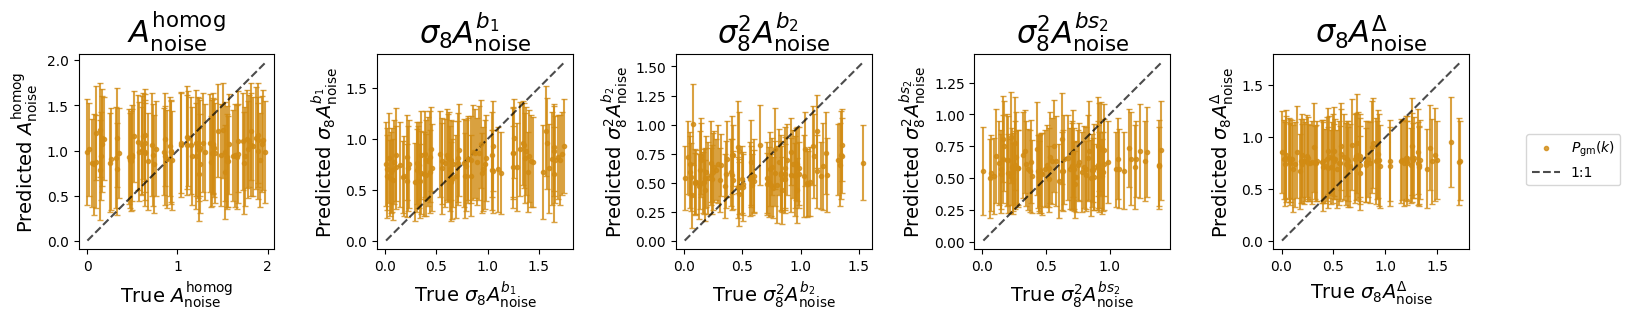

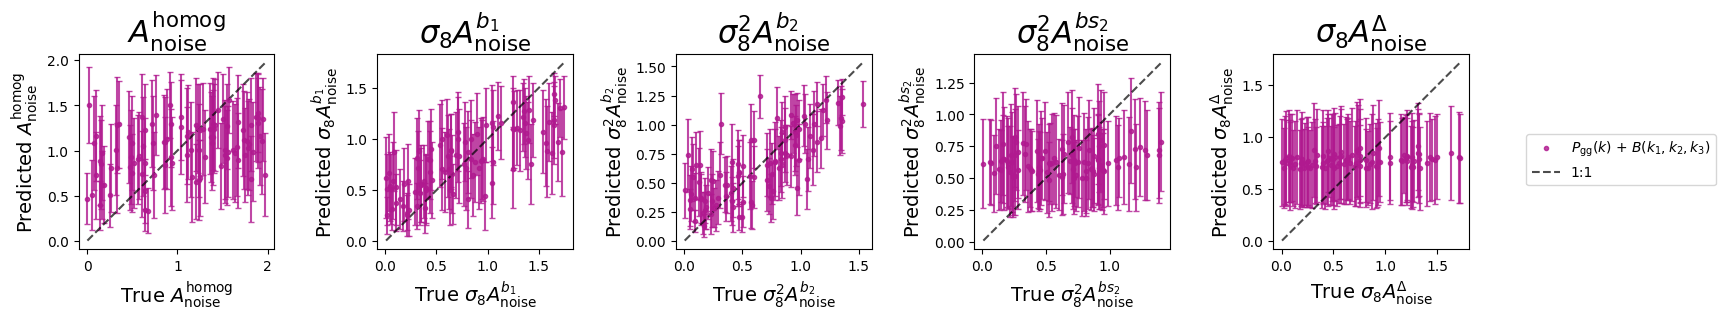

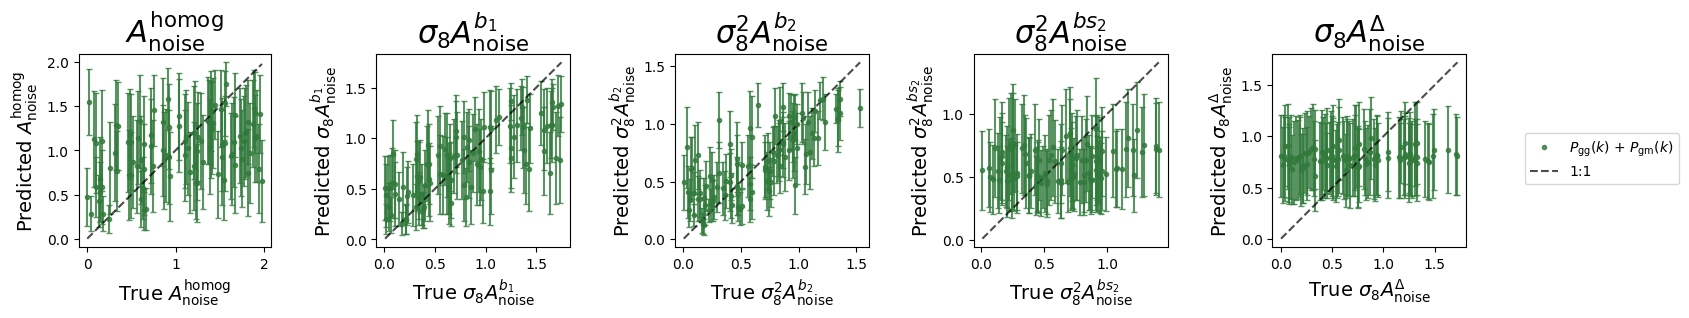

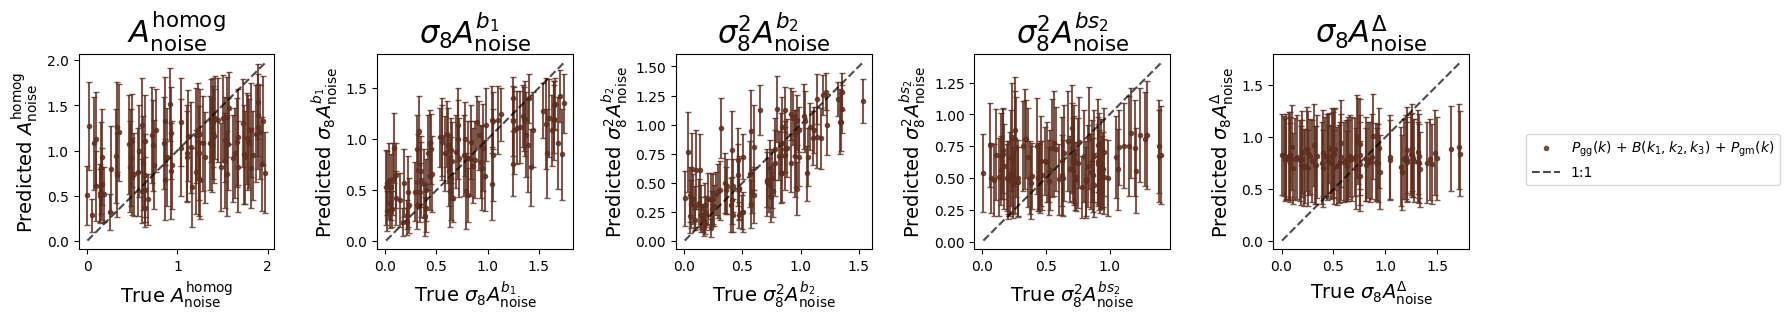

In [35]:
for idx_stat in range(len(statistics_arr)):
    fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat],
                        covs_pred_arr[idx_stat], param_names_show, 
                        param_names_plot=param_names_noise_rp, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

## shame

In [10]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.12701492 -0.33881766 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kb0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_bispec_kb0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pgm_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kb0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_bispec_kb0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_pgm_p5_n10000_biaszen_p4_n20

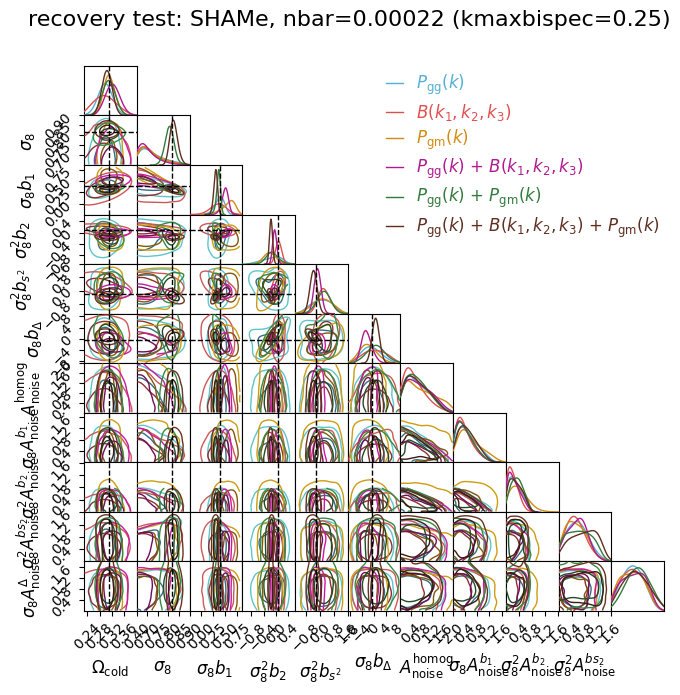

In [11]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]} (kmaxbispec=0.25)'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tags_mask[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents, fontsize_legend=12)

fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kb0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_bispec_kb0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pgm_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kb0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_bispec_kb0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_pgm_nbar0.00022_pred.npy
fn_samples = ../results/result

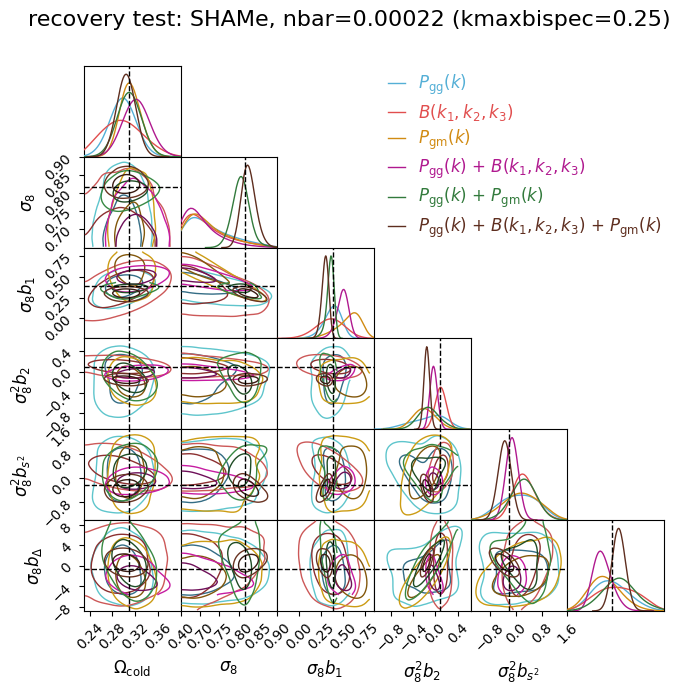

In [12]:
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents, fontsize_legend=12)

fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kb0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_bispec_kb0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pgm_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kb0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_bispec_kb0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_shame_pk_pgm_nbar0.00022_pred.npy
fn_samples = ../results/result

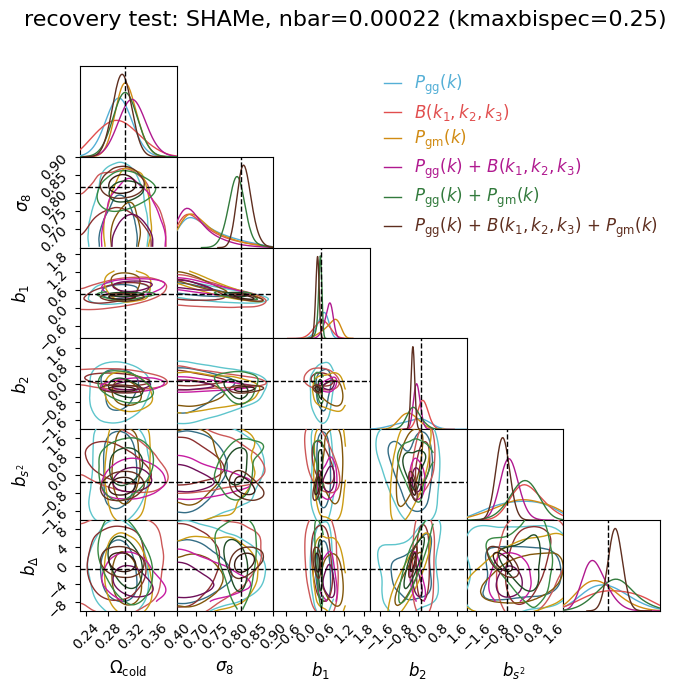

In [13]:
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents, fontsize_legend=12,
                        unreparameterize=True)